## E-commerce Market Intelligence Using Web-Scraped Amazon Data (1.4M Products)

This project analyzes a large-scale web-scraped Amazon product dataset containing 1.4 million product listings across hundreds of categories.

The goal is to generate market intelligence insights:
- Which categories are most competitive
- How pricing behaves across the marketplace
- What drives product demand
- Key metrics that matter for brands, sellers, and data vendors

---

### About the Dataset

This analysis uses the **Amazon Products Dataset 2023 (1.4M Products)**. A large-scale web-scraped catalog of Amazon listings collected in September 2023: *[Kaggle Dataset](https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products?select=amazon_products.csv)*

For each product in **amazon_products.scv**, the dataset provides following attributes:

- `asin` - Unique product identifier on Amazon
- `title` - Product title
- `imgURL` - Url of the product image
- `productURL` - Url of the product
- `stars` - Product rating (0 indicates no ratings available)
- `reviews` - Number of reviews (0 indicates no reviews available)
- `price` - Current “buy now” price (0 indicates price could not be retrieved)
- `listPrice` - Original list/MSRP price; 0 indicates no list price was available
- `category_id` - Numeric category identifier linking to the category mapping file
- `isBestSeller` - Whether the product has Amazon Best Seller status
- `boughtInLastMonth` - Number of units purchased in the last month

The dataset also includes a category mapping file, `amazon_categories.csv`, which contains:

- `id` - Category ID (foreign key for `category_id` in `amazon_products.csv`)
- `category_name` - Name of the category as on Amazon.com

Both files are linked through a foreign-key relationship:  
`amazon_products.category_id` → `amazon_categories.id`  
This join enables mapping each product to its corresponding category for category-level analysis.  

---

In [1]:
import duckdb
import pandas as pd
import numpy as np
import sklearn
import requests
import bs4
import shap
import matplotlib.pyplot as plt

### 1. Load Data

In [26]:
duckdb.sql("""
    CREATE OR REPLACE TABLE products AS
    SELECT *
    FROM read_csv_auto('../data/amazon_products.csv')
""")

In [3]:
duckdb.sql("SELECT * FROM products LIMIT 5").df()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400


In [4]:
duckdb.sql("""
    CREATE OR REPLACE TABLE categories AS
    SELECT *
    FROM read_csv_auto('../data/amazon_categories.csv')
""")

In [5]:
duckdb.sql("SELECT * FROM categories LIMIT 5")

┌───────┬──────────────────────────────────┐
│  id   │          category_name           │
│ int64 │             varchar              │
├───────┼──────────────────────────────────┤
│     1 │ Beading & Jewelry Making         │
│     2 │ Fabric Decorating                │
│     3 │ Knitting & Crochet Supplies      │
│     4 │ Printmaking Supplies             │
│     5 │ Scrapbooking & Stamping Supplies │
└───────┴──────────────────────────────────┘

### 2. Data Profiling

Profiling focuses on `price`, `listPrice`, `stars`, `reviews`. These columns directly impact analysis (pricing, demand, product quality).

In [6]:
duckdb.sql("""
SELECT
    COUNT(*) AS total_rows,
    SUM(price = 0) AS zero_price,
    SUM(listPrice = 0) AS zero_listPrice,
    SUM(stars = 0) AS zero_stars,
    SUM(reviews = 0) AS zero_reviews
FROM products;
""")

┌────────────┬────────────┬────────────────┬────────────┬──────────────┐
│ total_rows │ zero_price │ zero_listPrice │ zero_stars │ zero_reviews │
│   int64    │   int128   │     int128     │   int128   │    int128    │
├────────────┼────────────┼────────────────┼────────────┼──────────────┤
│    1426337 │      32772 │        1080503 │     131023 │      1130503 │
└────────────┴────────────┴────────────────┴────────────┴──────────────┘

### Category Distribution

In [7]:
duckdb.sql("""
SELECT 
    category_id, 
    COUNT(*) AS count
FROM products
GROUP BY category_id
ORDER BY count DESC;
""")

┌─────────────┬───────┐
│ category_id │ count │
│    int64    │ int64 │
├─────────────┼───────┤
│          91 │ 28619 │
│          84 │ 24660 │
│         270 │ 20846 │
│         114 │ 19822 │
│         118 │ 18994 │
│          95 │ 18514 │
│         110 │ 18258 │
│         112 │ 17679 │
│         116 │ 17393 │
│         123 │ 17005 │
│          ·  │    ·  │
│          ·  │    ·  │
│          ·  │    ·  │
│         191 │   141 │
│         196 │   140 │
│         125 │   139 │
│         256 │    94 │
│         193 │    78 │
│         195 │    76 │
│         186 │    50 │
│         185 │    42 │
│         102 │    40 │
│         194 │    22 │
├─────────────┴───────┤
│ 248 rows  2 columns │
│ (20 shown)          │
└─────────────────────┘

The dataset contains **1.42M products** spread across **248 categories**, but several fields show significant missing or incomplete information:

- 32,772 products have price = 0
→ These represent missing or failed extractions. Prices must be replaced with NULL to avoid bias.

- 1,080,503 products have listPrice = 0
→ This field is unreliable for most items. Discount analysis should be restricted to the subset where listPrice exists.

- 131,023 products have stars = 0

- 1,130,503 products have reviews = 0  
→ The majority of products have no rating/review data.  
→ Rating-based analysis will be meaningful only for the subset with non-zero reviews.

### 3. Data Cleaning

Check the duplicated rows

In [33]:
duckdb.sql("""
SELECT *
FROM products
GROUP BY ALL
HAVING COUNT(*) > 1;       
""")

┌─────────┬─────────┬─────────┬────────────┬────────┬─────────┬────────┬───────────┬─────────────┬──────────────┬───────────────────┐
│  asin   │  title  │ imgUrl  │ productURL │ stars  │ reviews │ price  │ listPrice │ category_id │ isBestSeller │ boughtInLastMonth │
│ varchar │ varchar │ varchar │  varchar   │ double │  int64  │ double │  double   │    int64    │   boolean    │       int64       │
├─────────┴─────────┴─────────┴────────────┴────────┴─────────┴────────┴───────────┴─────────────┴──────────────┴───────────────────┤
│                                                              0 rows                                                               │
└───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

To keep the analytical dataset clean:

- Ignored `imgUrl` and `productURL` to the final `products_clean` table.
- Converted zero values to NULL in fields where it is not meaningful (price = 0, listPrice = 0).
- Kept zeros for stars/reviews because zero = 'no ratings yet'

In [8]:
duckdb.sql("""
CREATE OR REPLACE TABLE products_clean AS
SELECT
    asin,
    title,
    stars,
    reviews,
    CASE WHEN price = 0 THEN NULL ELSE price END AS price,
    CASE WHEN listPrice = 0 THEN NULL ELSE listPrice END AS listPrice,
    category_id,
    isBestSeller,
    boughtInLastMonth
FROM products;
""")

In [9]:
duckdb.sql("SELECT * FROM products_clean LIMIT 5").df()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,NaN,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,209.99,104,False,1000
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,429.99,104,False,300
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,354.37,104,False,400
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,309.99,104,False,400


In [10]:
duckdb.sql("""
SELECT
    COUNT(*) AS total_rows,
    COUNT(price) AS non_null_price,
    COUNT(listPrice) AS non_null_listPrice,
    COUNT(*) FILTER (WHERE stars > 0) AS non_zero_stars,
    COUNT(*) FILTER (WHERE reviews > 0) AS non_zero_reviews
FROM products_clean;
""")

┌────────────┬────────────────┬────────────────────┬────────────────┬──────────────────┐
│ total_rows │ non_null_price │ non_null_listPrice │ non_zero_stars │ non_zero_reviews │
│   int64    │     int64      │       int64        │     int64      │      int64       │
├────────────┼────────────────┼────────────────────┼────────────────┼──────────────────┤
│    1426337 │        1393565 │             345834 │        1295314 │           295834 │
└────────────┴────────────────┴────────────────────┴────────────────┴──────────────────┘



After converting invalid zeros to NULLs during preprocessing, I rechecked the integrity of the cleaned dataset.

Key findings:

- Price: 1.39M rows have a valid price.
- List Price: Only ~345k products include a list price. This field is sparse and will only be used for subset discount analysis.
- Ratings & Reviews:
    - All rows include a numeric stars and reviews value.
    - Many products have stars = 0 or reviews = 0, which means “no rating” rather than missing data.

### 4.1. Join Categories

In [11]:
duckdb.sql("""
CREATE OR REPLACE TABLE products_full AS
SELECT
    p.*,
    c.category_name
FROM products_clean AS p
LEFT JOIN categories AS c
ON p.category_id = c.id;
""")

In [12]:
duckdb.sql("SELECT * FROM products_full LIMIT 5").df()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
0,B07DNT9MVR,"Cake Decorating Icing Piping Tip Set, 10 X-lar...",4.7,0,13.80,NaN,170,False,700,Kitchen & Dining
1,B07NNNL939,"Adjustable Measuring Spoon White,Creative Doub...",4.3,0,9.95,10.99,170,False,700,Kitchen & Dining
2,B01IN8GK8Q,"The Mentalist Whole Bean Coffee, Medium Dark R...",4.6,0,15.75,NaN,170,False,900,Kitchen & Dining
3,B0BDLR4S48,Smash Burger Press - Heavy Duty Hamburger Pres...,4.6,0,22.99,NaN,170,False,900,Kitchen & Dining
4,B00VFYPK82,"VAHDAM, Original English Breakfast Black Tea L...",4.5,0,24.99,NaN,170,False,600,Kitchen & Dining


### 4.2. Join Category Mapping

The original dataset contains 265+ highly granular product categories, many of which are sub-sub-categories (e.g., Girls’ Jewelry, Smart Home: Lighting, Computer External Components).
While this level of detail is useful for Amazon, it makes high-level analysis noisy, fragmented, and difficult to interpret.

To simplify the analysis, I auto generated a grouped `category_map.csv` that assigns each detailed Amazon category to one of several broader parent groups:

In [13]:
duckdb.sql("""
CREATE OR REPLACE TABLE category_map AS
SELECT *
FROM read_csv('../data/category_map.csv', 
    header=true,
    delim=',', 
    quote='"'
)
""")

In [14]:
duckdb.sql("""
SELECT DISTINCT
    parent_category
FROM category_map
""")

┌──────────────────────────┐
│     parent_category      │
│         varchar          │
├──────────────────────────┤
│ Clothing                 │
│ Sports & Outdoors        │
│ Toys & Games             │
│ Luggage & Travel         │
│ Beauty                   │
│ Industrial               │
│ Home & Kitchen           │
│ Baby Care                │
│ Health & Wellness        │
│ Office & School          │
│ Arts & Crafts            │
│ Electronics              │
│ Tools & Home Improvement │
│ Smart Home               │
│ Automotive               │
│ Pets                     │
│ Other                    │
├──────────────────────────┤
│         17 rows          │
└──────────────────────────┘

In [15]:
duckdb.sql("SELECT * FROM category_map LIMIT 5")

┌───────┬──────────────────────────────────┬─────────────────┐
│  id   │          category_name           │ parent_category │
│ int64 │             varchar              │     varchar     │
├───────┼──────────────────────────────────┼─────────────────┤
│     1 │ Beading & Jewelry Making         │ Arts & Crafts   │
│     2 │ Fabric Decorating                │ Arts & Crafts   │
│     3 │ Knitting & Crochet Supplies      │ Arts & Crafts   │
│     4 │ Printmaking Supplies             │ Arts & Crafts   │
│     5 │ Scrapbooking & Stamping Supplies │ Arts & Crafts   │
└───────┴──────────────────────────────────┴─────────────────┘

In [16]:
duckdb.sql("""
CREATE OR REPLACE TABLE products_final AS
SELECT
    p.*,
    m.parent_category
FROM products_full AS p
LEFT JOIN category_map AS m
    ON p.category_id = m.id;
""")

In [17]:
duckdb.sql("SELECT * FROM products_final LIMIT 5").df()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name,parent_category
0,B07DNT9MVR,"Cake Decorating Icing Piping Tip Set, 10 X-lar...",4.7,0,13.80,NaN,170,False,700,Kitchen & Dining,Home & Kitchen
1,B07NNNL939,"Adjustable Measuring Spoon White,Creative Doub...",4.3,0,9.95,10.99,170,False,700,Kitchen & Dining,Home & Kitchen
2,B01IN8GK8Q,"The Mentalist Whole Bean Coffee, Medium Dark R...",4.6,0,15.75,NaN,170,False,900,Kitchen & Dining,Home & Kitchen
3,B0BDLR4S48,Smash Burger Press - Heavy Duty Hamburger Pres...,4.6,0,22.99,NaN,170,False,900,Kitchen & Dining,Home & Kitchen
4,B00VFYPK82,"VAHDAM, Original English Breakfast Black Tea L...",4.5,0,24.99,NaN,170,False,600,Kitchen & Dining,Home & Kitchen


### 5. EDA

#### 5.1. Category Competition (Leaf-Level Categories from *amazon_categories.csv*)

In [18]:
duckdb.sql("""
SELECT
    category_name,
    COUNT(*) AS product_count
FROM products_final
GROUP BY category_name
ORDER BY product_count DESC;
""")

┌────────────────────────────────────────────────┬───────────────┐
│                 category_name                  │ product_count │
│                    varchar                     │     int64     │
├────────────────────────────────────────────────┼───────────────┤
│ Girls' Clothing                                │         28619 │
│ Boys' Clothing                                 │         24660 │
│ Toys & Games                                   │         20846 │
│ Men's Shoes                                    │         19822 │
│ Women's Handbags                               │         18994 │
│ Girls' Jewelry                                 │         18514 │
│ Men's Clothing                                 │         18258 │
│ Men's Accessories                              │         17679 │
│ Women's Clothing                               │         17393 │
│ Women's Jewelry                                │         17005 │
│        ·                                       │            

- Clothing subcategories dominate (Girls', Boys’, Men's, Women's), each carrying 20k–28k products, indicating very high saturation.
- Toys & Games is a major competitive category with 20k+ products, consistently appearing among top leaf categories.
- Fashion accessories (handbags, jewelry, watches) also rank highly, showing a crowded and diverse marketplace.
- Many specialized or niche categories (e.g., Smart Home Lighting, Online Video Game Services, Garment Bags) have very low counts (<150), highlighting long-tail segments with low supply.

#### 5.2. Parent Category Competition (Auto generated *category_map.csv*)

In [19]:
duckdb.sql("""
SELECT
    parent_category,
    COUNT(*) AS product_count
FROM products_final
GROUP BY parent_category
ORDER BY product_count DESC;
""")

┌──────────────────────────┬───────────────┐
│     parent_category      │ product_count │
│         varchar          │     int64     │
├──────────────────────────┼───────────────┤
│ Clothing                 │        278800 │
│ Toys & Games             │        200868 │
│ Industrial               │        158633 │
│ Home & Kitchen           │        132297 │
│ Electronics              │        130889 │
│ Automotive               │        101155 │
│ Tools & Home Improvement │         81760 │
│ Arts & Crafts            │         79410 │
│ Baby Care                │         55140 │
│ Beauty                   │         53445 │
│ Luggage & Travel         │         42873 │
│ Pets                     │         42223 │
│ Health & Wellness        │         24840 │
│ Office & School          │         22252 │
│ Sports & Outdoors        │         19578 │
│ Smart Home               │          2035 │
│ Other                    │           139 │
├──────────────────────────┴───────────────┤
│ 17 rows 

- Clothing is the dominant parent category with 278k+ listings, far exceeding all others.
- Toys & Games ranks second with 200k+ products, confirming it as a major vertical.
- Industrial, Home & Kitchen, Electronics, and Automotive form strong mid-sized categories, each exceeding 100k listings.
- Smart Home remains a small category (<2.5k products), positioning it as a niche vertical compared to the major categories.

#### 5.3. Price Analysis

In [20]:
duckdb.sql("""
SELECT
    category_name,
    ROUND(AVG(price), 2) AS avg_price,
    MIN(price) AS min_price,
    MAX(price) AS max_price,
    MEDIAN(price) AS median_price
FROM products_final
WHERE price IS NOT NULL
GROUP BY category_name
ORDER BY avg_price DESC;
""")

┌────────────────────────────────────────────────┬───────────┬───────────┬───────────┬──────────────┐
│                 category_name                  │ avg_price │ min_price │ max_price │ median_price │
│                    varchar                     │  double   │  double   │  double   │    double    │
├────────────────────────────────────────────────┼───────────┼───────────┼───────────┼──────────────┤
│ Computer Servers                               │   1561.52 │      7.46 │   16468.7 │       546.89 │
│ Computers & Tablets                            │    571.87 │      6.17 │   5844.99 │        399.0 │
│ Smart Home: Home Entertainment                 │    397.71 │     19.99 │    2596.0 │       299.99 │
│ Smart Home: Vacuums and Mops                   │    344.96 │     88.88 │    1349.0 │      238.995 │
│ Smart Home - Heating & Cooling                 │    261.73 │     11.99 │    1509.0 │       214.33 │
│ Luggage Sets                                   │    237.56 │      9.99 │     712

- High-price categories are technology-driven, led by:
  - Computer Servers (avg $1,561)
  - Computers & Tablets (avg $571)
  - Smart Home: Home Entertainment (avg $397)  
    These categories offer strong premium potential and higher margins.

- Clear segmentation emerges between Tech and Lifestyle categories:
  - **Tech:** high average prices, wide price ranges, strong premium positioning
  - **Lifestyle/Party supplies:** low-price items, saturated markets, low profit per SKU

- Median price highlights pricing dynamics in high-end categories:
  - In categories like Computer Servers, the median price ($546) is far below the average
  - This indicates that a small number of ultra-expensive products inflate the average, while most items sit in mid-price ranges.

In [21]:
duckdb.sql("""
SELECT
    parent_category,
    ROUND(AVG(price), 2) AS avg_price,
    MIN(price) AS min_price,
    MAX(price) AS max_price,
    MEDIAN(price) AS median_price
FROM products_final
WHERE price IS NOT NULL AND parent_category <> 'Other'
GROUP BY parent_category
ORDER BY avg_price DESC;
""")

┌──────────────────────────┬───────────┬───────────┬───────────┬──────────────┐
│     parent_category      │ avg_price │ min_price │ max_price │ median_price │
│         varchar          │  double   │  double   │  double   │    double    │
├──────────────────────────┼───────────┼───────────┼───────────┼──────────────┤
│ Smart Home               │    165.97 │      5.99 │    2596.0 │         99.0 │
│ Electronics              │    115.17 │       0.1 │  19731.81 │        26.98 │
│ Office & School          │     71.31 │      1.55 │   11998.0 │        21.99 │
│ Automotive               │      48.3 │      0.29 │    4778.0 │        22.96 │
│ Luggage & Travel         │     46.57 │       0.6 │   2909.55 │        23.99 │
│ Clothing                 │     45.24 │      0.01 │    5750.0 │        24.99 │
│ Tools & Home Improvement │     41.58 │      0.01 │    8999.0 │        19.99 │
│ Home & Kitchen           │     36.43 │      0.35 │    6023.0 │        19.99 │
│ Toys & Games             │     33.71 │

- Smart Home is the highest-priced parent category (avg. $165), followed by Electronics (avg. $115).
- Office & School, Automotive, and Luggage & Travel fall into a mid-price range ($45–$71).
- Clothing, Tools & Home Improvement, Home & Kitchen, Toys & Games, Industrial, and Sports sit in the lower mid-range ($20–$40).
- Baby Care, Pets, and Health & Wellness cluster around $22–$28.
- Arts & Crafts and Beauty are the lowest-priced groups ($13–$19), reflecting low-ticket consumables.

#### 5.4. Rating & Review Behavior

In [22]:
duckdb.sql("""
SELECT
    category_name,
    ROUND(AVG(stars), 1) AS avg_stars,
    ROUND(AVG(reviews), 1) AS avg_reviews
FROM products_final
GROUP BY category_name
ORDER BY avg_reviews DESC;
""")

┌───────────────────────────────────────────┬───────────┬─────────────┐
│               category_name               │ avg_stars │ avg_reviews │
│                  varchar                  │  double   │   double    │
├───────────────────────────────────────────┼───────────┼─────────────┤
│ Smart Home: Security Cameras and Systems  │       4.2 │      7956.1 │
│ Smart Home: Voice Assistants and Hubs     │       3.3 │      2331.4 │
│ Diet & Sports Nutrition                   │       4.3 │      2285.8 │
│ Video Games                               │       4.3 │      2276.0 │
│ Home Décor Products                       │       4.4 │      2121.4 │
│ Kids' Home Store                          │       4.5 │      1991.6 │
│ Wellness & Relaxation Products            │       4.3 │      1930.2 │
│ Makeup                                    │       4.2 │      1717.4 │
│ Televisions & Video Products              │       4.3 │      1504.0 │
│ Foot, Hand & Nail Care Products           │       4.2 │      1

- Smart Home categories lead in engagement, with extremely high review volumes (e.g., Security Cameras ~7,956; Voice Assistants ~2,331 reviews).
- Most top categories hold strong ratings (4.2–4.4 stars), indicating consistent product satisfaction.
- High reviews + high ratings highlight strong product-market fit, especially in Smart Home and Fitness-related categories.

In [23]:
duckdb.sql("""
SELECT
    parent_category,
    ROUND(AVG(stars), 1) AS avg_stars,
    ROUND(AVG(reviews), 1) AS avg_reviews
FROM products_final
WHERE parent_category <> 'Other'
GROUP BY parent_category
ORDER BY avg_reviews DESC;
""")

┌──────────────────────────┬───────────┬─────────────┐
│     parent_category      │ avg_stars │ avg_reviews │
│         varchar          │  double   │   double    │
├──────────────────────────┼───────────┼─────────────┤
│ Smart Home               │       4.1 │      1138.7 │
│ Beauty                   │       4.3 │       793.0 │
│ Health & Wellness        │       4.3 │       369.7 │
│ Office & School          │       4.1 │       323.0 │
│ Sports & Outdoors        │       4.4 │       267.5 │
│ Pets                     │       3.8 │       250.6 │
│ Toys & Games             │       3.9 │       244.3 │
│ Home & Kitchen           │       4.2 │       221.8 │
│ Electronics              │       3.8 │       207.0 │
│ Automotive               │       4.1 │       174.9 │
│ Tools & Home Improvement │       4.3 │       135.1 │
│ Clothing                 │       4.0 │       116.1 │
│ Baby Care                │       4.0 │        76.6 │
│ Arts & Crafts            │       4.0 │        46.1 │
│ Industri

- Smart Home has the highest engagement (~1,139 reviews), showing strong demand for connected devices.
- Beauty and Health & Wellness follow with high review volumes, indicating frequent, high-turnover purchases.
- Office & School and Sports & Outdoors show solid mid-level engagement.
- Toys & Games, Home & Kitchen, Electronics, and Pets have moderate review activity.
- Automotive, Tools & Home Improvement, Clothing, Baby Care, Arts & Crafts, and Industrial have lower review counts.
- Ratings remain consistently high (4.0–4.4) across most categories, reflecting strong product satisfaction.

#### 5.5. Bestseller Analysis

In [36]:
duckdb.sql("""
SELECT
    isBestSeller,
    ROUND(AVG(price), 2) AS avg_price,
    ROUND(AVG(stars), 2) AS avg_stars,
    ROUND(AVG(reviews), 2) AS avg_reviews,
    ROUND(AVG(boughtInLastMonth), 2) AS avg_sales,
    COUNT(*) AS count_products
FROM products_final
GROUP BY isBestSeller
""")

┌──────────────┬───────────┬───────────┬─────────────┬───────────┬────────────────┐
│ isBestSeller │ avg_price │ avg_stars │ avg_reviews │ avg_sales │ count_products │
│   boolean    │  double   │  double   │   double    │  double   │     int64      │
├──────────────┼───────────┼───────────┼─────────────┼───────────┼────────────────┤
│ false        │     44.48 │       4.0 │       167.9 │    128.86 │        1417817 │
│ true         │      29.9 │      4.49 │     2318.63 │   2325.36 │           8520 │
└──────────────┴───────────┴───────────┴─────────────┴───────────┴────────────────┘

- **Bestsellers are cheaper** on average ($29.9 vs. $44.5), suggesting lower price improves conversion.
- They have higher ratings (4.49★ vs. 3.99★) and more reviews (~2,318 vs. ~168), indicating strong social proof.
- **Sales volume is higher for bestsellers** (2,325 vs. 129 units/month), confirming that popularity compounds visibility and demand.
- Only 0.6% of products become bestsellers, making it a highly competitive and selective segment.

#### 5.6. Demand Driver Analysis

In [37]:
duckdb.sql("""
SELECT
    ROUND(corr(price, boughtInLastMonth), 3) AS corr_price_sales,
    ROUND(corr(stars, boughtInLastMonth), 3) AS corr_stars_sales,
    ROUND(corr(reviews, boughtInLastMonth), 3) AS corr_reviews_sales
FROM products_final
""")

┌──────────────────┬──────────────────┬────────────────────┐
│ corr_price_sales │ corr_stars_sales │ corr_reviews_sales │
│      double      │      double      │       double       │
├──────────────────┼──────────────────┼────────────────────┤
│           -0.027 │            0.063 │              0.148 │
└──────────────────┴──────────────────┴────────────────────┘

- Price has almost no impact on sales (corr = –0.027).
- Star ratings have a weak positive effect (corr = 0.063).
- Review count has the strongest correlation with sales but still weak (corr = 0.148).
    - While not a strong predictor, **review volume is the most influential factor** among the three.

#### 5.7. Discount Analysis

In [58]:
duckdb.sql("""
SELECT
    MIN(price)       AS min_price,
    MAX(price)       AS max_price,
    MIN(listPrice)   AS min_listPrice,
    MAX(listPrice)   AS max_listPrice
FROM products_discount;
""")

┌───────────┬───────────┬───────────────┬───────────────┐
│ min_price │ max_price │ min_listPrice │ max_listPrice │
│  double   │  double   │    double     │    double     │
├───────────┼───────────┼───────────────┼───────────────┤
│      0.01 │  19731.81 │          0.99 │        999.99 │
└───────────┴───────────┴───────────────┴───────────────┘

In [59]:
duckdb.sql("""
SELECT 
    COUNT(*) AS total_rows,
    SUM(price > listPrice) AS price_above_listPrice,
    SUM(price = listPrice) AS equal_price_listPrice,
    SUM(price < listPrice) AS price_below_listPrice
FROM products_discount;
""")

┌────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│ total_rows │ price_above_listPrice │ equal_price_listPrice │ price_below_listPrice │
│   int64    │        int128         │        int128         │        int128         │
├────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│    1426337 │                   451 │                   228 │                345106 │
└────────────┴───────────────────────┴───────────────────────┴───────────────────────┘

- 451 products have incorrect/negative discounts
- 228 No discount
- 345,106 Proper discounted products
- Most products have NULL listPrice

These 451 cases might be bad seller inputs or price-listPrice mismatch. Since they are less than 0.03% of data will exclude them.

In [60]:
duckdb.sql("""
CREATE OR REPLACE TABLE products_discount AS
SELECT
    *,
    (listPrice - price) AS discount_amount,
    CASE 
        WHEN listPrice > 0 AND price <= listPrice 
            THEN (listPrice - price) / listPrice * 100
        ELSE NULL
    END AS discount_pct,
    COALESCE((price <= listPrice) AND ((listPrice - price) > 0), FALSE) AS is_discounted
FROM products_final;
""")

In [62]:
duckdb.sql("SELECT * FROM products_discount LIMIT 5").df()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name,parent_category,discount_amount,discount_pct,is_discounted
0,B07DNT9MVR,"Cake Decorating Icing Piping Tip Set, 10 X-lar...",4.7,0,13.80,NaN,170,False,700,Kitchen & Dining,Home & Kitchen,NaN,NaN,False
1,B07NNNL939,"Adjustable Measuring Spoon White,Creative Doub...",4.3,0,9.95,10.99,170,False,700,Kitchen & Dining,Home & Kitchen,1.04,9.463148,True
2,B01IN8GK8Q,"The Mentalist Whole Bean Coffee, Medium Dark R...",4.6,0,15.75,NaN,170,False,900,Kitchen & Dining,Home & Kitchen,NaN,NaN,False
3,B0BDLR4S48,Smash Burger Press - Heavy Duty Hamburger Pres...,4.6,0,22.99,NaN,170,False,900,Kitchen & Dining,Home & Kitchen,NaN,NaN,False
4,B00VFYPK82,"VAHDAM, Original English Breakfast Black Tea L...",4.5,0,24.99,NaN,170,False,600,Kitchen & Dining,Home & Kitchen,NaN,NaN,False


In [64]:
duckdb.sql("""
SELECT
    COUNT(*) AS total_products,
    SUM(is_discounted::INT) AS discounted_products,
    ROUND(AVG(is_discounted::INT) * 100, 2) AS percent_discounted,
    ROUND(AVG(discount_pct), 2) AS avg_discount_pct,
    ROUND(MEDIAN(discount_pct), 2) AS median_discount_pct
FROM products_discount;
""")

┌────────────────┬─────────────────────┬────────────────────┬──────────────────┬─────────────────────┐
│ total_products │ discounted_products │ percent_discounted │ avg_discount_pct │ median_discount_pct │
│     int64      │       int128        │       double       │      double      │       double        │
├────────────────┼─────────────────────┼────────────────────┼──────────────────┼─────────────────────┤
│        1426337 │              345106 │               24.2 │            20.95 │               17.24 │
└────────────────┴─────────────────────┴────────────────────┴──────────────────┴─────────────────────┘

- 24.2% of products are discounted.
- Among discounted items, the average discount is 20.95%, meaning sellers generally use medium-level promotions.
- The median discount is 17.24%, lower than the mean → a few high-discount items pull the average up.

In [65]:
df = duckdb.sql("""
SELECT
    FLOOR(discount_pct / 20) * 20 AS bucket_start,
    FLOOR(discount_pct / 20) * 20 + 20 AS bucket_end,
    COUNT(*) AS product_count
FROM products_discount
WHERE discount_pct IS NOT NULL
GROUP BY bucket_start, bucket_end
ORDER BY bucket_start;
""").df()

In [66]:
df["bucket"] = df["bucket_start"].astype(int).astype(str) + "–" + df["bucket_end"].astype(int).astype(str)
df

,bucket_start,bucket_end,product_count,bucket
0,0.0,20.0,191138,0–20
1,20.0,40.0,115747,20–40
2,40.0,60.0,33904,40–60
3,60.0,80.0,4261,60–80
4,80.0,100.0,284,80–100


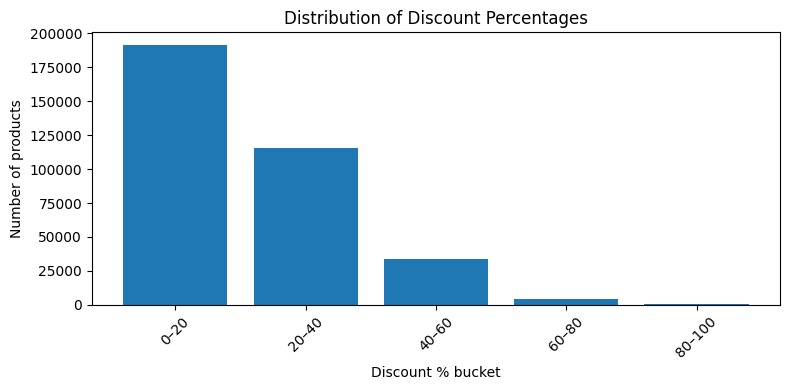

In [74]:
plt.figure(figsize=(8, 4))
plt.bar(df["bucket"], df["product_count"])
plt.xlabel("Discount % bucket")
plt.ylabel("Number of products")
plt.title("Distribution of Discount Percentages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Most discounted products fall in the 0–20% range, indicating light discounting is most common.
- The 20–40% range is also sizable, showing moderate discounts are widely used.
- 40–60% discounts are noticeably less frequent but still present.
- Deep discounts (60–80% and 80–100%) are rare.

Overall, the discount landscape is skewed toward smaller reductions.

#### Category Level Discounts

In [70]:
duckdb.sql("""
SELECT
    parent_category,
    ROUND(AVG(listPrice), 2) AS avg_list_price,
    ROUND(AVG(price), 2) AS avg_price,
    ROUND(AVG(discount_pct), 2) AS avg_discount_pct
FROM products_discount
WHERE discount_pct IS NOT NULL
GROUP BY parent_category
ORDER BY avg_discount_pct DESC;
""")

┌──────────────────────────┬────────────────┬───────────┬──────────────────┐
│     parent_category      │ avg_list_price │ avg_price │ avg_discount_pct │
│         varchar          │     double     │  double   │      double      │
├──────────────────────────┼────────────────┼───────────┼──────────────────┤
│ Clothing                 │          64.01 │     46.83 │            23.69 │
│ Sports & Outdoors        │          37.78 │     28.57 │            23.26 │
│ Smart Home               │         202.97 │    153.73 │            22.83 │
│ Beauty                   │           22.3 │     17.03 │             22.6 │
│ Health & Wellness        │          30.26 │     23.15 │            21.68 │
│ Home & Kitchen           │          45.11 │     34.87 │            20.88 │
│ Tools & Home Improvement │          49.94 │     39.18 │            20.86 │
│ Electronics              │         101.93 │     80.85 │            20.59 │
│ Toys & Games             │          35.98 │     28.36 │            20.47 │

- Categories like Clothing, Sports & Outdoors, and Smart Home show the highest discount levels (≈22–24%), indicating strong competition and frequent promotions.
- More stable categories such as Office & School, Industrial, and Arts & Crafts have lower discounts (≈18–19%), reflecting steadier pricing and fewer promotions.

In [78]:
duckdb.sql("""
SELECT
    FLOOR(discount_pct / 20) * 20 AS bucket_start,
    FLOOR(discount_pct / 20) * 20 + 20 AS bucket_end,
    ROUND(AVG(stars), 2) AS avg_stars,
    COUNT(*) AS product_count
FROM products_discount
WHERE discount_pct IS NOT NULL
  AND stars IS NOT NULL
GROUP BY bucket_start, bucket_end
ORDER BY bucket_start;
""")

┌──────────────┬────────────┬───────────┬───────────────┐
│ bucket_start │ bucket_end │ avg_stars │ product_count │
│    double    │   double   │  double   │     int64     │
├──────────────┼────────────┼───────────┼───────────────┤
│          0.0 │       20.0 │       4.2 │        191138 │
│         20.0 │       40.0 │      4.26 │        115747 │
│         40.0 │       60.0 │      4.23 │         33904 │
│         60.0 │       80.0 │       4.1 │          4261 │
│         80.0 │      100.0 │       3.8 │           284 │
└──────────────┴────────────┴───────────┴───────────────┘

#### Overall comparison (discounted vs non-discounted)

In [79]:
duckdb.sql("""
SELECT
    is_discounted,
    ROUND(AVG(stars), 2) AS avg_stars,
    COUNT(*) AS product_count
FROM products_discount
WHERE stars IS NOT NULL
GROUP BY is_discounted;
""")

┌───────────────┬───────────┬───────────────┐
│ is_discounted │ avg_stars │ product_count │
│    boolean    │  double   │     int64     │
├───────────────┼───────────┼───────────────┤
│ false         │      3.93 │       1081231 │
│ true          │      4.22 │        345106 │
└───────────────┴───────────┴───────────────┘

- Discounted products have higher ratings (4.22) compared to non-discounted products (3.93).